In [3]:
import IPython.display as ipd
import librosa
import librosa.display
from scipy.io import wavfile
import soundfile as sf
import os
from os.path import basename
import cv2
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import tempfile
import time
import math
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes

seed = 0
np.random.seed(seed)
import random
random.seed(seed)

/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
def readData(data_folder_path, audio_length = 45, n_mels = 128, val_split = 0.2):
    """
    Return consolidated and preprocessed wav file melspectograms and labels 
    imported from the provided locations 
    
    Arguments:
    data_folder_path  -- Path of folder containing training audio folders
    audio_length      -- Length of output audio (milliseconds)
    """
    
    # Get list of speakers for train-val split
    speakers = []
    for file_ in glob.glob(data_folder_path+'/*/*.wav'):
        if file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]=='_background_noise_':
            continue            
        speakers.append(file_[file_.rfind('/')+1:file_.find('_')])
    
    # Split into training and validation
    train_speakers, val_speakers = train_test_split(list(set(speakers)), test_size=val_split, random_state=42)
    train_size = len([i for i in speakers if i in train_speakers])
    val_size = len([i for i in speakers if i in val_speakers])
    # Add more space for 'silence' labels
    train_size+=1950
    val_size+=450
    
    label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
    
    # Initialize arrays for storing data
    train_features = np.zeros((train_size, audio_length, n_mels, 2), np.float32)
    val_features = np.zeros((val_size, audio_length, n_mels, 2), np.float32)
    train_labels = np.zeros((train_size, len(label_list)), np.int64)
    val_labels = np.zeros((val_size, len(label_list)), np.int64)
    
    # For shuffling
    p = np.random.permutation(train_size)
    
    # Iterate over audio files to extract features and labels
    tr_num, val_num = 0, 0
    length = []
    for file_ in glob.glob(data_folder_path+'/*/*.wav'):
        label = file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]
        if label=='_background_noise_':
            continue
        if label not in label_list[:-2]:
            unknown_label = label
            label = 'unknown'
#             if np.random.choice([True, False], p=[15/16, 1/16]):
#                 continue
            
        
        speaker = file_[file_.rfind('/')+1:file_.find('_')]
        
        X, sample_rate = sf.read(file_)
        X, _ = librosa.effects.trim(X) # Remove leading and trailing silence
        file_feature = librosa.feature.melspectrogram(X, sample_rate, n_mels=n_mels, hop_length=370)
        file_feature2 = librosa.feature.mfcc(X, sample_rate, n_mfcc=n_mels, hop_length=370)
#         length.append([file_feature.shape[1], label])
        file_feature = cv2.resize(librosa.power_to_db(file_feature, ref=np.max), (audio_length, n_mels))
        file_feature2 = cv2.resize(file_feature2, (audio_length, n_mels))
        file_feature = np.stack((file_feature, file_feature2), axis=2)
        
        if (speaker in val_speakers and label != 'unknown') or (label == 'unknown' and 
                                                                speaker in val_speakers and
                                                                unknown_label in ['house', 'dog', 'two', 'five']):
            val_features[val_num] = file_feature.reshape((audio_length, n_mels, 2))
            val_labels[val_num, label_list.index(label)] = 1.0
            val_num+=1
        elif (speaker in train_speakers and label != 'unknown') or (label == 'unknown' and
                                                                    speaker in train_speakers and
                                                                    unknown_label not in ['house', 'dog', 'two', 'five']):
            train_features[p[tr_num]] = file_feature.reshape((audio_length, n_mels, 2))
            train_labels[p[tr_num], label_list.index(label)] = 1.0
            tr_num+=1
        
        if (tr_num+val_num)%10000==0:
            print(tr_num+val_num)
    
    # Add 'silence' labels
    for file_ in glob.glob(data_folder_path+'/_background_noise_/*.wav'):
        X, sample_rate = librosa.load(file_, res_type='kaiser_fast')
        file_feature = librosa.power_to_db(librosa.feature.melspectrogram(X, sample_rate, n_mels=n_mels),
                                           ref=np.max)
        file_feature2 = librosa.feature.mfcc(X, sample_rate, n_mfcc=n_mels)
        file_feature = np.stack((file_feature, file_feature2), axis=2)
        
        random_samples = [file_feature[:,i:i+audio_length,:].reshape((audio_length, n_mels, 2))
                          for i in np.random.randint(file_feature.shape[1]-audio_length, size=(400))]
        
        train_features[p[tr_num:tr_num+325]] = random_samples[:325]
        train_labels[p[tr_num:tr_num+325], label_list.index('silence')] = 1.0
        val_features[val_num:val_num+75] = random_samples[325:]
        val_labels[val_num:val_num+75, label_list.index('silence')] = 1.0
        tr_num+=325
        val_num+=75
        
    # Remove blank rows
    idx_tr = np.where(np.sum(train_labels, 1)==0)[0]
    idx_val = np.where(np.sum(val_labels, 1)==0)[0]
    train_labels = np.delete(train_labels, idx_tr, 0)
    train_features = np.delete(train_features, idx_tr, 0)
    val_labels = np.delete(val_labels, idx_val, 0)
    val_features = np.delete(val_features, idx_val, 0)
    
    return {'train_X' : train_features, 'train_y' : train_labels,
           'val_X' : val_features, 'val_y' : val_labels}

In [5]:
data = readData('./Data/train/audio/', n_mels=128)

10000
20000
20000
30000
40000
50000


In [9]:
train_data = {'train_X' : data['train_X'], 'train_y' : data['train_y']}

In [6]:
pickle.dump(data, open('./Data/train_val.pickle', 'wb'))

In [8]:
data = pickle.load(open('./Data/train_val_balanced.pickle', 'rb'))

In [16]:
# pickle.dump(data, open('./Data/train_val.pickle', 'wb'))
# pickle.dump(data, open('./Data/train_val_balanced.pickle', 'wb'))
# pickle.dump(data, open('./Data/train_val_binary.pickle', 'wb'))

### Model

In [125]:
class Config():
    im_height = 128
    im_width = 45
    im_depth = 1
    num_epochs = 200
    batch_size = 24
    
    network_width = 15
    
    # CNN
    conv1_patch_size = 3
    conv2_patch_size = 2
    conv3_patch_size = 2
    conv1_depth = network_width*1
    conv2_depth = network_width*3
    conv3_depth = network_width*5
    
    # RNN
    num_layers = 1
    rnn_num_hidden = 128    
    
    # Dense
    num_hidden = 256
    
    # Number of classes
    num_classes = 12
    
config = Config()

In [145]:
class speechModel(object):
    
    def __init__(self, config, savefile):
        
        self.config = config
        self.savefile = savefile
        tf.reset_default_graph()
        
    def read(self):
        
        self.eval = tf.placeholder(tf.bool)
        
    def net(self, images, labels):

        # Define CNN variables
        intitalizer = tf.contrib.layers.xavier_initializer_conv2d()
        self.layer1_weights = tf.Variable(intitalizer(
            [self.config.conv1_patch_size, self.config.conv1_patch_size, 
             self.config.im_depth, self.config.conv1_depth]),
                                          name='conv1_W')
        self.layer1_biases = tf.Variable(tf.zeros([self.config.conv1_depth]), name='conv1_b')
        self.layer2_weights = tf.Variable(intitalizer(
            [self.config.conv2_patch_size, self.config.conv2_patch_size, 
             self.config.conv1_depth, self.config.conv2_depth]), name='conv2_W')
        self.layer2_biases = tf.Variable(tf.zeros([self.config.conv2_depth]), name='conv2_b')
        self.layer3_weights = tf.Variable(intitalizer(
            [self.config.conv3_patch_size, self.config.conv3_patch_size, 
             self.config.conv2_depth, self.config.conv3_depth]), name='conv3_W')
        self.layer3_biases = tf.Variable(tf.zeros([self.config.conv3_depth]), name='conv3_b')

        self.layer4_weights = tf.Variable(tf.truncated_normal(
            [(16*6*self.config.conv3_depth),
             self.config.num_hidden], stddev=0.1), name='dense_W')
        self.layer4_biases = tf.Variable(tf.constant(1.0, shape=[self.config.num_hidden]), name='dense_W')
        self.layer5_weights = tf.Variable(tf.truncated_normal([self.config.num_hidden, self.config.num_classes], 
                                                              stddev=0.1), name='out_W')
        self.layer5_biases = tf.Variable(tf.constant(1.0, shape=[self.config.num_classes]), name='out_W')

        
        # ==================1==================
        # CNN
        with tf.name_scope('CNN_1'):
            conv = tf.nn.conv2d(images, self.layer1_weights, [1, 1, 1, 1],
                                padding='SAME')
            hidden = tf.nn.relu(conv + self.layer1_biases)
            conv1_out = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                  padding='SAME')
            conv1_out = tf.where(self.eval, conv1_out, tf.nn.dropout(conv1_out, 0.9))
        
        # ==================2==================
        # CNN
        with tf.name_scope('CNN_2'):
            conv = tf.nn.conv2d(conv1_out, self.layer2_weights, [1, 1, 1, 1],
                                padding='SAME')
            hidden = tf.nn.relu(conv + self.layer2_biases)
            conv2_out = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                  padding='SAME')
            conv2_out = tf.where(self.eval, conv2_out, tf.nn.dropout(conv2_out, 0.9))

        # ==================3==================
        # CNN
        with tf.name_scope('CNN_3'):
            conv = tf.nn.conv2d(conv2_out, self.layer3_weights, [1, 1, 1, 1],
                                padding='SAME')
            hidden = tf.nn.relu(conv + self.layer3_biases)
            conv3_out = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                  padding='SAME')
            conv3_out = tf.where(self.eval, conv3_out, tf.nn.dropout(conv3_out, 0.9))
        

        with tf.name_scope('Dense'):
            reshape = tf.reshape(conv3_out, [-1,  
                                                  tf.shape(conv3_out)[1]*tf.shape(conv3_out)[2]*tf.shape(conv3_out)[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, self.layer4_weights) + self.layer4_biases)
            hidden = tf.where(self.eval, hidden, tf.nn.dropout(hidden, 0.6))
            
            # Doing the affine projection
            logits = tf.matmul(hidden, self.layer5_weights) + self.layer5_biases

        # Reshaping back to the original shape
        logits = tf.reshape(logits, [-1, self.config.num_classes])

        # For saving model
        self.saver = tf.train.Saver()

        # Training computation
        self.loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))

        # Optimizer
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            self.optimizer = tf.train.AdamOptimizer(0.0001).minimize(self.loss)

        # Predictions for the training, validation, and test data.
        self.prediction = tf.nn.sigmoid(logits)
        self.labels = labels
        
    def train(self, tr_X, tr_y, val_X, val_y):
        num_steps = int((self.config.num_epochs*len(data['train_X']))/self.config.batch_size)
        tf.reset_default_graph()
        
        # Prepare input pipeline
        images = tf.placeholder(tf.float32, shape=(None, self.config.im_width,
                                                   self.config.im_height, self.config.im_depth))
        labels = tf.placeholder(tf.float32, shape=(None, self.config.num_classes))

        dataset = tf.data.Dataset.from_tensor_slices((images, labels))
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.prefetch(1)
        dataset = dataset.batch(self.config.batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
        val_dataset = val_dataset.prefetch(1)
        val_dataset = val_dataset.batch(self.config.batch_size)
        
        iterator = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
        next_example, next_label = iterator.get_next()
        training_init_op = iterator.make_initializer(dataset)
        validation_init_op = iterator.make_initializer(val_dataset)
        
        self.read()
        self.net(next_example, next_label)
        # The op for initializing the variables.
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        # TensorBoard Summaries
        train_cost_summary = tf.summary.scalar("training_cost", self.loss)
        
        with tf.Session() as sess:
            
            summaries = tf.summary.merge_all()
            writer = tf.summary.FileWriter("./TensorBoard/lines", sess.graph)            
            sess.run(init_op)
            print('Initialized')
            
            start = time.time()
            steps_time = start
            epoch_time = start
            
            epoch_train_cost = []
            train_predictions = []
            train_labels = []
            best_val = 0
            step = 0
            
            # Train
            for ep in range(1, self.config.num_epochs+1):
                feed_dict = {images : tr_X, labels : tr_y}
                sess.run(training_init_op, feed_dict=feed_dict)
                feed_dict = {self.eval : False}
                while True:
                    try:
                        _, l, predictions, summ = sess.run([self.optimizer, self.loss,
                                                          self.prediction, summaries],
                                                               feed_dict=feed_dict)
                        writer.add_summary(summ, step)
                        step+=1
                    except tf.errors.OutOfRangeError:
                        break
                
                # At epoch completion
                print('Epoch', ep, 'Completed')
                print('Time =', round(time.time() - epoch_time), 'seconds')
                epoch_time = time.time()
                
                # Evaluation - Training set
                feed_dict = {images : tr_X, labels : tr_y}
                sess.run(validation_init_op, feed_dict=feed_dict)
                feed_dict = {self.eval : True}
                ep_predictions, ep_labels = [], []
                while True:
                    try:
                        predictions, labels_ = sess.run([self.prediction, self.labels], feed_dict=feed_dict)
                        ep_predictions.append(predictions)
                        ep_labels.append(labels_)
                    except tf.errors.OutOfRangeError:
                        break
                ep_predictions, ep_labels = np.concatenate(ep_predictions), np.concatenate(ep_labels)
                tr_acc = 100*np.sum(np.argmax(ep_predictions, 1)==np.argmax(ep_labels, 1)) / ep_predictions.shape[0]
                tr_loss= log_loss(ep_labels, ep_predictions)
                
                # Evaluation - Validation set
                feed_dict = {images : val_X, labels : val_y}
                sess.run(validation_init_op, feed_dict=feed_dict)
                feed_dict = {self.eval : True}
                ep_predictions, ep_labels = [], []
                while True:
                    try:
                        predictions, labels_ = sess.run([self.prediction, self.labels], feed_dict=feed_dict)
                        ep_predictions.append(predictions)
                        ep_labels.append(labels_)
                    except tf.errors.OutOfRangeError:
                        break
                ep_predictions, ep_labels = np.concatenate(ep_predictions), np.concatenate(ep_labels)
                val_acc = 100*np.sum(np.argmax(ep_predictions, 1)==np.argmax(ep_labels, 1)) / ep_predictions.shape[0]
                val_loss= log_loss(ep_labels, ep_predictions)
                writer.add_summary(tf.Summary(value=[tf.Summary.Value(tag="val_cost", simple_value=val_loss)]), ep)
                
                print('Cost: Training =', tr_loss, 'Validation =', val_loss)
                print('Accuracy: Training =', "{0:.2f}".format(tr_acc), 'Validation =', "{0:.2f}".format(val_acc))
                print('-------------------------------------------------------------------------------')
                
                if val_acc>best_val:
                    best_val = val_acc
                    self.saver.save(sess, self.savefile)
                
            writer.close()
            print('Total runtime =', round(time.time() - start), 'seconds')
            
    def evaluate(self, X, y):
        with tf.Session() as sess:
            # restore the model
            self.saver.restore(sess, self.savefile)
            # Prepare input pipeline
            images = tf.placeholder(tf.float32, shape=(None, self.config.im_width, self.config.im_height,
                                                       self.config.im_depth))
            labels = tf.placeholder(tf.float32, shape=(None, self.config.num_classes))

            dataset = tf.data.Dataset.from_tensor_slices((images, labels))
            dataset = dataset.prefetch(1)
            dataset = dataset.batch(self.config.batch_size)
            iterator = dataset.make_initializable_iterator()
            next_example, next_label = iterator.get_next()

            self.read()
            self.net(next_example, next_label)
            
            feed_dict = {images : X, labels : y}
            sess.run(training_init_op, feed_dict=feed_dict)
            feed_dict = {self.eval : True}
            eval_predictions, eval_labels = [], []
            while True:  
                try:
                    predictions, labels_ = sess.run([self.prediction, self.labels], feed_dict=feed_dict)
                    eval_predictions.append(predictions)
                    eval_labels.append(labels_)
                except tf.errors.OutOfRangeError:
                    break
            eval_predictions, eval_labels = np.concatenate(eval_predictions), np.concatenate(eval_labels)
            eval_acc = 100*np.sum(np.argmax(eval_predictions, 1)==np.argmax(eval_labels, 1)) / eval_predictions.shape[0]
            eval_loss= log_loss(eval_labels, eval_predictions)
            
            return eval_loss, eval_acc
            
    def predict(self, X):
        with tf.Session() as sess:
            # restore the model
            self.saver.restore(sess, self.savefile)
            # Prepare input pipeline
            images = tf.placeholder(tf.float32, shape=(None, self.config.im_width, self.config.im_height, 1))

            dataset = tf.data.Dataset.from_tensor_slices((images))
            dataset = dataset.prefetch(1)
            dataset = dataset.batch(self.config.batch_size)
            iterator = dataset.make_initializable_iterator()
            next_example = iterator.get_next()

            self.read()
            self.net(next_example, next_label)
            
            val_predictions = []
            feed_dict = {images : X}
            sess.run(iterator.initializer, feed_dict=feed_dict)
            feed_dict = {self.eval : True}
            while True:                
                try:
                    predictions = sess.run([self.prediction], feed_dict=feed_dict)
                    val_predictions.append(predictions)
                except tf.errors.OutOfRangeError:
                    break
                        
            val_predictions = np.concatenate(val_predictions)
            return val_predictions

In [146]:
model = speechModel(config=config, savefile='./saved_model/model_binary_v28Dec17_v0')
model.train(data['train_X'], data['train_y'], data['val_X'], data['val_y'])

Initialized
Epoch 1 Completed
Time = 10 seconds
Epoch 2 Completed
Time = 10 seconds


KeyboardInterrupt: 

In [135]:
pred = speechModel(config=config, savefile='./saved_model/model_v28Dec17_v0')
pred.read()
pred.net()
print(pred.evaluate(data['train_X'], data['train_y']))

ValueError: Tried to convert 'input' to a tensor and failed. Error: None values not supported.

In [257]:
pred = speechModel(config=config, savefile='./saved_model/model_v28Dec17_v0')
pred.read()
pred.net()

val_predictions = pred.predict(data['val_X'])

INFO:tensorflow:Restoring parameters from ./saved_model/model_v28Dec17_v0


In [258]:
np.sum(np.argmax(val_predictions, 1) == np.argmax(data['val_y'], 1))/val_predictions.shape[0]

0.88800303720577067

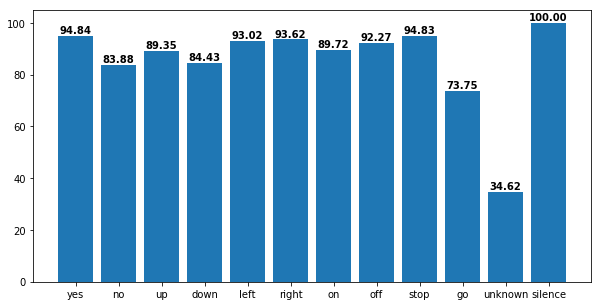

85.3611585238


In [259]:
class_acc = []
for i in range(12):
    idx = np.where(np.argmax(data['val_y'], 1)==i)[0]
    preds = np.argmax(val_predictions[idx], 1)
#     preds[np.where(val_predictions[idx,10]>0.5)] = 10
    class_acc.append((100*np.sum(np.argmax(data['val_y'][idx], 1) == preds))/idx.shape[0])

label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
plt.figure(figsize=(10,5))
plt.bar(np.arange(12), class_acc)
plt.xticks(np.arange(12), label_list)
for i, v in enumerate(class_acc):
    plt.text(i, v+1, str('{0:.2f}'.format(v)), color='black', fontweight='bold', ha='center')
plt.show()
print(np.mean(class_acc))

In [20]:
y, sr = librosa.load('./Data/train/audio/four/0a9f9af7_nohash_0.wav')
X, _ = librosa.effects.trim(y)
y2, sr = librosa.load('./Data/train/audio/left/1a6eca98_nohash_0.wav')
X2, _ = librosa.effects.trim(y2)

In [21]:
librosa.output.write_wav('temp.wav', np.concatenate((X[:X.shape[0]//2], X2[X2.shape[0]//2:]), axis=0), sr)

#### Binary Known/Unknown Model 

In [433]:
def readUnknownData(data_folder_path, audio_length = 45, n_mels = 128, val_split = 0.2):
    """
    Return consolidated and preprocessed wav file melspectograms and labels 
    imported from the provided locations 
    
    Arguments:
    data_folder_path  -- Path of folder containing training audio folders
    audio_length      -- Length of output audio (milliseconds)
    """
    
    # Get list of speakers for train-val split
    speakers = []
    for file_ in glob.glob(data_folder_path+'/*/*.wav'):
        if file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]=='_background_noise_':
            continue            
        speakers.append(file_[file_.rfind('/')+1:file_.find('_')])
    
    # Split into training and validation
    train_speakers, val_speakers = train_test_split(list(set(speakers)), test_size=val_split, random_state=42)
    train_size = len([i for i in speakers if i in train_speakers])
    val_size = len([i for i in speakers if i in val_speakers])
    # Add more space for 'silence' labels
    train_size+=1950
    val_size+=450
    
    label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
    new_label_list = ['known', 'unknown']
    
    # Initialize arrays for storing data
    train_features = np.zeros((train_size, audio_length, n_mels, 1), np.float32)
    val_features = np.zeros((val_size, audio_length, n_mels, 1), np.float32)
    train_labels = np.zeros((train_size, 1), np.int64)
    val_labels = np.zeros((val_size, 1), np.int64)
    
    # For shuffling
    p = np.random.permutation(train_size)
    
    # Iterate over audio files to extract features and labels
    tr_num, val_num = 0, 0
    length = []
    for file_ in glob.glob(data_folder_path+'/*/*.wav'):
        label = file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]
        if label=='_background_noise_':
            continue
        if label not in label_list[:-2]:
            unknown_label = label
            label = 'unknown'
            if np.random.choice([True, False], p=[0.3125, 0.6875]):
                continue
            
        
        speaker = file_[file_.rfind('/')+1:file_.find('_')]
        
        X, sample_rate = librosa.load(file_, res_type='kaiser_fast')
        X, _ = librosa.effects.trim(X) # Remove leading and trailing silence
        file_feature = librosa.feature.melspectrogram(X, sample_rate, n_mels=n_mels)
#         length.append([file_feature.shape[1], label])
        file_feature = cv2.resize(librosa.power_to_db(file_feature, ref=np.max), (audio_length, n_mels))
        
        if (speaker in val_speakers and label != 'unknown') or (label == 'unknown' and 
                                                                speaker in val_speakers and
                                                                unknown_label in ['house', 'dog', 'two', 'five']):
            val_features[val_num] = file_feature.reshape((audio_length, n_mels, 1))
            if label == 'unknown':
                val_labels[val_num] = 1.0
            val_num+=1
        elif (speaker in train_speakers and label != 'unknown') or (label == 'unknown' and
                                                                    speaker in train_speakers and
                                                                    unknown_label not in ['house', 'dog', 'two', 'five']):
            train_features[p[tr_num]] = file_feature.reshape((audio_length, n_mels, 1))
            if label == 'unknown':
                train_labels[p[tr_num]] = 1.0
            tr_num+=1
        
        if (tr_num+val_num)%10000==0:
            print(tr_num+val_num)
    
    # Add 'silence' labels
    for file_ in glob.glob(data_folder_path+'/_background_noise_/*.wav'):
        X, sample_rate = librosa.load(file_, res_type='kaiser_fast')
        file_feature = librosa.power_to_db(librosa.feature.melspectrogram(X, sample_rate, n_mels=n_mels),
                                           ref=np.max)
        
        random_samples = [file_feature[:,i:i+audio_length].reshape((audio_length, n_mels, 1))
                          for i in np.random.randint(file_feature.shape[1]-audio_length, size=(400))]
        
        train_features[p[tr_num:tr_num+325]] = random_samples[:325]
        train_labels[p[tr_num:tr_num+325]] = 0.0
        val_features[val_num:val_num+75] = random_samples[325:]
        val_labels[val_num:val_num+75] = 0.0
        tr_num+=325
        val_num+=75
        
    # Remove blank rows
    idx_tr = np.where(np.sum(train_features, (1,2,3))==0)[0]
    idx_val = np.where(np.sum(val_features, (1,2,3))==0)[0]
    train_labels = np.delete(train_labels, idx_tr, 0)
    train_features = np.delete(train_features, idx_tr, 0)
    val_labels = np.delete(val_labels, idx_val, 0)
    val_features = np.delete(val_features, idx_val, 0)
    
    return {'train_X' : train_features, 'train_y' : train_labels,
           'val_X' : val_features, 'val_y' : val_labels}

In [33]:
class Config():
    im_height = 128
    im_width = 45
    num_epochs = 200
    batch_size = 24
    
    network_width = 15
    
    # CNN
    conv1_patch_size = 3
    conv2_patch_size = 2
    conv3_patch_size = 2
    conv1_depth = network_width*1
    conv2_depth = network_width*3
    conv3_depth = network_width*5
    
    # RNN
    num_layers = 1
    rnn_num_hidden = 128    
    
    # Dense
    num_hidden = 256
    
    # Number of classes
    num_classes = 1
    
config = Config()

In [36]:
class speechModel(object):
    
    def __init__(self, config, savefile):
        
        self.config = config
        self.savefile = savefile
        tf.reset_default_graph()
        
    def read(self):
        
        self.images = tf.placeholder(tf.float32,
                                          shape=(None, self.config.im_width,
                                                 self.config.im_height, 1))
        self.labels = tf.placeholder(tf.float32, shape=(None, self.config.num_classes))
        self.val = tf.placeholder(tf.bool)
        
    def net(self):

        # Define CNN variables
        intitalizer = tf.contrib.layers.xavier_initializer_conv2d()
        self.layer1_weights = tf.Variable(intitalizer(
            [self.config.conv1_patch_size, self.config.conv1_patch_size, 1, self.config.conv1_depth]),
                                          name='conv1_W')
        self.layer1_biases = tf.Variable(tf.zeros([self.config.conv1_depth]), name='conv1_b')
        self.layer2_weights = tf.Variable(intitalizer(
            [self.config.conv2_patch_size, self.config.conv2_patch_size, 
             self.config.conv1_depth, self.config.conv2_depth]), name='conv2_W')
        self.layer2_biases = tf.Variable(tf.zeros([self.config.conv2_depth]), name='conv2_b')
        self.layer3_weights = tf.Variable(intitalizer(
            [self.config.conv3_patch_size, self.config.conv3_patch_size, 
             self.config.conv2_depth, self.config.conv3_depth]), name='conv3_W')
        self.layer3_biases = tf.Variable(tf.zeros([self.config.conv3_depth]), name='conv3_b')

        self.layer4_weights = tf.Variable(tf.truncated_normal(
            [(16*6*self.config.conv3_depth),
             self.config.num_hidden], stddev=0.1), name='dense_W')
        self.layer4_biases = tf.Variable(tf.constant(1.0, shape=[self.config.num_hidden]), name='dense_W')
        self.layer5_weights = tf.Variable(tf.truncated_normal([self.config.num_hidden, self.config.num_classes], 
                                                              stddev=0.1), name='out_W')
        self.layer5_biases = tf.Variable(tf.constant(1.0, shape=[self.config.num_classes]), name='out_W')

        
        # ==================1==================
        # CNN
        with tf.name_scope('CNN_1'):
#             conv = tf.layers.batch_normalization(
#                 inputs=self.images, axis=-1, momentum=0.999, epsilon=0.001, center=True, scale=True, training = not self.val)
            conv = tf.nn.conv2d(self.images, self.layer1_weights, [1, 1, 1, 1],
                                padding='SAME')
#             conv = tf.layers.batch_normalization(
#                 inputs=conv, axis=-1, momentum=0.999, epsilon=0.001, center=True, scale=True, training = not self.val)
            hidden = tf.nn.relu(conv + self.layer1_biases)
            conv1_out = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                  padding='SAME')
            if not self.val:
                conv1_out = tf.nn.dropout(conv1_out, 0.75)
        
        # ==================2==================
        # CNN
        with tf.name_scope('CNN_2'):
            conv = tf.nn.conv2d(conv1_out, self.layer2_weights, [1, 1, 1, 1],
                                padding='SAME')
#             conv = tf.layers.batch_normalization(
#                 inputs=conv, axis=-1, momentum=0.999, epsilon=0.001, center=True, scale=True, training = not self.val)
            hidden = tf.nn.relu(conv + self.layer2_biases)
            conv2_out = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                  padding='SAME')
            if not self.val:
                conv2_out = tf.nn.dropout(conv2_out, 0.7)

        # ==================3==================
        # CNN
        with tf.name_scope('CNN_3'):
            conv = tf.nn.conv2d(conv2_out, self.layer3_weights, [1, 1, 1, 1],
                                padding='SAME')
#             conv = tf.layers.batch_normalization(
#                 inputs=conv, axis=-1, momentum=0.999, epsilon=0.001, center=True, scale=True, training = not self.val)
            hidden = tf.nn.relu(conv + self.layer3_biases)
            conv3_out = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                  padding='SAME')
            if not self.val:
                conv3_out = tf.nn.dropout(conv3_out, 0.7)
        

        with tf.name_scope('Dense'):
#             self.output = tf.concat(self.output, 2)[-1]
            
            # Reshaping to apply the same weights over the timesteps
#             reshape_rnn = tf.reshape(self.output, [-1, 2*self.config.rnn_num_hidden])
            
            reshape = tf.reshape(conv3_out, [-1,  
                                                  tf.shape(conv3_out)[1]*tf.shape(conv3_out)[2]*tf.shape(conv3_out)[3]])
#             reshape = tf.concat((reshape_rnn, reshape_conv), 1)
            hidden = tf.nn.relu(tf.matmul(reshape, self.layer4_weights) + self.layer4_biases)
            if not self.val:
                hidden = tf.nn.dropout(hidden, 0.5)
            # Doing the affine projection
            logits = tf.matmul(hidden, self.layer5_weights) + self.layer5_biases

        # Reshaping back to the original shape
        logits = tf.reshape(logits, [self.config.batch_size, self.config.num_classes])

        # For saving model
        self.saver = tf.train.Saver()

        # Training computation
#         class_indices = tf.stack(list(np.arange(10))+[11])
#         class_labels = tf.gather(self.labels, class_indices, axis=1)
#         class_logits = tf.gather(logits, class_indices, axis=1)
#         unknown_index = tf.stack([10])
#         unknown_labels = tf.gather(self.labels, unknown_index, axis=1)
#         unknown_logits = tf.gather(logits, unknown_index, axis=1)
#         self.loss = tf.reduce_mean(
#             tf.nn.softmax_cross_entropy_with_logits(labels=class_labels, logits=class_logits)+
#             tf.nn.sigmoid_cross_entropy_with_logits(labels=unknown_labels, logits=unknown_logits))
        self.loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels, logits=logits))

        # Optimizer
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            self.optimizer = tf.train.AdamOptimizer(0.00005).minimize(self.loss)

        # Predictions for the training, validation, and test data.
        self.prediction = tf.nn.sigmoid(logits)
        
    def accuracy(self, predictions, labels):
        preds = predictions>0.5
        preds = preds.astype(np.int32)
        return (100.0 * np.sum(preds == labels)
                / predictions.shape[0])

    def train(self):
        num_steps = int((self.config.num_epochs*len(data['train_X']))/self.config.batch_size)
        tf.reset_default_graph()

        self.read()
        self.val = False
        self.net()

        # The op for initializing the variables.
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        # TensorBoard Summaries
        train_cost_summary = tf.summary.scalar("training_cost", self.loss)
        
        with tf.Session() as sess:
            
            summaries = tf.summary.merge_all()
            writer = tf.summary.FileWriter("./TensorBoard/lines", sess.graph)            
            sess.run(init_op)
            print('Initialized')
            
            start = time.time()
            steps_time = start
            epoch_time = start
            
            epoch = 1
            epoch_train_cost = []
            train_predictions = []
            train_labels = []
            best_val = 0
            
            for step in range(num_steps):
                offset = (step * self.config.batch_size) % (len(data['train_X']) - self.config.batch_size)
                batch_images = data['train_X'][offset:(offset + self.config.batch_size), :, :]
                batch_labels = data['train_y'][offset:(offset + self.config.batch_size)]

                feed_dict = {self.images : batch_images, self.labels : batch_labels}
                
                self.val = False
                _, l, predictions, summ = sess.run([self.optimizer, self.loss,
                                                          self.prediction, summaries],
                                                               feed_dict=feed_dict)
                writer.add_summary(summ, step)
                epoch_train_cost.append(l)
                train_predictions.append(predictions)
                train_labels.append(batch_labels)

                if (step!=0 and (step+1) % int(len(data['train_X'])/self.config.batch_size) == 0):
                    print('Epoch', epoch, 'Completed')
                    print('Time =', round(time.time() - epoch_time), 'seconds')
                    
                    # Get val loss and accuracy
                    epoch_val_cost = []
                    val_predictions = []
                    val_labels = []
                    num_val_steps = int((len(data['val_X']))/self.config.batch_size)
                    for val_step in range(num_val_steps):
                        val_offset = (val_step * self.config.batch_size) % (len(data['val_X']) - self.config.batch_size+1)
                        batch_val_images = data['val_X'][val_offset:(val_offset + self.config.batch_size), :, :]
                        batch_val_labels = data['val_y'][val_offset:(val_offset + self.config.batch_size)]
                        
                        val_feed_dict = {self.images : batch_val_images, self.labels : batch_val_labels}
                        
                        self.val = True
                        val_cost, predictions = sess.run([self.loss, self.prediction], feed_dict=val_feed_dict)
                        
                        epoch_val_cost.append(val_cost)
                        val_predictions.append(predictions)
                        val_labels.append(batch_val_labels)
                    
                    # Writing values to TensoLogs and printing epoch results
                    epoch_val_cost = np.mean(epoch_val_cost)
                    writer.add_summary(tf.Summary(value=[tf.Summary.Value(tag="val_cost", 
                                                                          simple_value=epoch_val_cost)]), epoch)
                    
                    train_predictions = np.concatenate(train_predictions)
                    val_predictions = np.concatenate(val_predictions)
                    train_labels = np.concatenate(train_labels)
                    val_labels = np.concatenate(val_labels)
                    
                    val_acc = self.accuracy(val_predictions.reshape((val_predictions.shape[0],
                                                                                           self.config.num_classes)),
                                                        val_labels)
                    
                    print('Cost: Training =', np.mean(epoch_train_cost), 
                          'Validation =', epoch_val_cost)
                    print('Accuracy: Training =', self.accuracy(train_predictions.reshape((train_predictions.shape[0],
                                                                                           self.config.num_classes)),
                                                                train_labels), 
                          'Validation =', val_acc)
                    print('-------------------------------------------------------------------------------')
                    if val_acc > best_val:
                        best_val = val_acc
                        self.saver.save(sess, self.savefile)
                    epoch_train_cost = []
                    train_predictions = []
                    train_labels = []
                    epoch_time = time.time()
                    epoch+=1
            writer.close()
            print('Total runtime =', round(time.time() - start), 'seconds')
            
    def predict(self, X):
        with tf.Session() as sess:
            # restore the model
            self.saver.restore(sess, self.savefile)
            val_predictions = []
            num_val_steps = int((len(X))/self.config.batch_size)
            for val_step in range(num_val_steps):
                val_offset = (val_step * self.config.batch_size) % (len(X) - self.config.batch_size+1)
                batch_val_images = X[val_offset:(val_offset + self.config.batch_size), :, :]
                val_predictions.append(sess.run(self.prediction, feed_dict={self.images : batch_val_images}))
            val_predictions = np.concatenate(val_predictions)
            return val_predictions.reshape((val_predictions.shape[0], self.config.num_classes))

In [37]:
model = speechModel(config=config, savefile='./saved_model/model_binary_v28Dec17_v0')
model.train()

Initialized
Epoch 1 Completed
Time = 14 seconds
Cost: Training = 9.41087 Validation = 0.956079
Accuracy: Training = 50.4547312487 Validation = 46.8385214008
-------------------------------------------------------------------------------
Epoch 2 Completed
Time = 14 seconds
Cost: Training = 0.800889 Validation = 0.694182
Accuracy: Training = 50.1967095851 Validation = 56.14461738
-------------------------------------------------------------------------------
Epoch 3 Completed
Time = 14 seconds
Cost: Training = 0.724882 Validation = 0.646661
Accuracy: Training = 50.6335581443 Validation = 62.5648508431
-------------------------------------------------------------------------------
Epoch 4 Completed
Time = 14 seconds
Cost: Training = 0.705882 Validation = 0.634357
Accuracy: Training = 50.7689556509 Validation = 63.813229572
-------------------------------------------------------------------------------
Epoch 5 Completed
Time = 14 seconds
Cost: Training = 0.699604 Validation = 0.656963
Accu

KeyboardInterrupt: 

In [30]:
config_val = Config()
config_val.batch_size = 1
pred = speechModel(config=config_val, savefile='./saved_model/model_binary_v28Dec17_v0')
pred.val_images = data['val_X']
pred.val_labels = data['val_y']
pred.read()
pred.val=True
pred.net()

val_predictions = pred.predict(pred.val_images)

INFO:tensorflow:Restoring parameters from ./saved_model/model_v28Dec17_v0


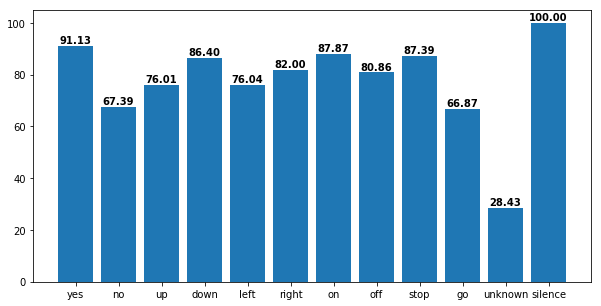

77.5326101643


In [31]:
class_acc = []
for i in range(12):
    idx = np.where(np.argmax(data['val_y'], 1)==i)[0]
    preds = np.argmax(val_predictions[idx], 1)
    preds[np.where(val_predictions[idx,10]>0.5)] = 10
    class_acc.append((100*np.sum(np.argmax(data['val_y'][idx], 1) == preds))/idx.shape[0])

label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
plt.figure(figsize=(10,5))
plt.bar(np.arange(12), class_acc)
plt.xticks(np.arange(12), label_list)
for i, v in enumerate(class_acc):
    plt.text(i, v+1, str('{0:.2f}'.format(v)), color='black', fontweight='bold', ha='center')
plt.show()
print(np.mean(class_acc))